In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import random
from mpmath import mp
from mpl_toolkits import mplot3d
import time 
from tqdm import tqdm 
from copy import copy

In [2]:
class envir():
    def __init__(self):
        self.phi = 4
        self.S = np.array([1,1,1,1])
    
    def step(self,task,s,jobsize):
        s_old = s[task]
        reward = 0
        
        if(s_old==jobsize[task] or s_old==0):
            s_new = 0
        else:
            s_new = s_old+1
        
        if(s_old==0):
            reward = -1000
        elif(s_old!=0 and s_new!=0):
            reward = 0
        else:
            reward = 1

        new_state = [0,0,0,0]
        for i in range(4):
            if i==task:
                new_state[i] = s_new
            else:
                new_state[i] = s[i]
        
        return new_state,reward
    
    def getjob(self):
        mean_log = np.log(30)
        std_dev_log = 0.6
        num_samples = 4
        discretized_values = np.arange(1, 76, 0.5)
        # Sample from log-normal distribution and clip
        sampled_values_clipped = np.clip(np.random.lognormal(mean_log, std_dev_log, num_samples), 1, 75)

        # Digitize the clipped values
        sampled_values = discretized_values[np.digitize(sampled_values_clipped, discretized_values)]
        j = [0]*len(sampled_values)
        #print(sampled_values)
        for i in range(len(sampled_values)):
            j[i] = (sampled_values[i]-1)/(0.5) + 1        
        return j

In [3]:
env = envir()
print(env.getjob())

[57.0, 108.0, 61.0, 77.0]


In [4]:
class Agent():
    def __init__(self,alpha,gamma):
        self.Q_values = np.zeros((151,151))
        self.phi = 4
        self.S = np.array([6,6,6,6])
        self.alpha = alpha
        self.gamma = gamma
def select_task(s,M):
        k = []
        for i in range(4):
            k.append(M[s[i]])
        #print(k)
        max_index = np.argmax(k)  # Get the index of the maximum value
        return max_index

def choose_arm(s,W,epsilon):
        wl= []
        p = np.array([0,0,0,0])
        if np.random.random() < epsilon:
            for i in range(len(p)):
                #if s[i]!=0:
                    wl.append(i)
            arm_to_pull = np.random.choice(wl,1)[0]
            return arm_to_pull
        else:
            p2 = {}
            for i in range(len(p)):
                #if s[i]!=0:
                    p2[i] = W[s[i]]
            max_key = max(p2, key=p2.get)
            return max_key
    

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:15<00:00,  4.59it/s]


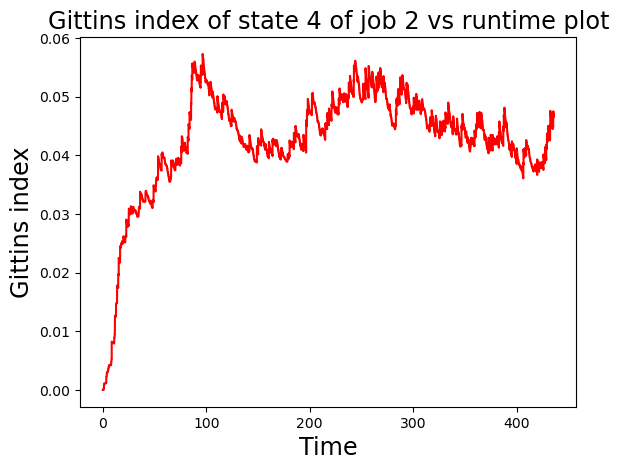

[-1.00000000e+05  1.18892216e+00  1.20272505e+00  1.22447167e+00
  1.25256362e+00  1.28905602e+00  1.33246069e+00  1.38299260e+00
  1.44110638e+00  1.50435790e+00  1.58639564e+00  1.60835090e+00
  1.76202559e+00  1.95746020e+00  1.72629091e+00  1.91220125e+00
  2.24838744e+00  2.48549624e+00  2.50186636e+00  2.33068754e+00
  2.74544393e+00  2.60267460e+00  2.80502468e+00  3.12058751e+00
  3.12548033e+00  3.28816771e+00  3.47182461e+00  3.70290593e+00
  3.36637988e+00  3.75747507e+00  3.44989238e+00  3.71355358e+00
  3.76074541e+00  4.30418336e+00  4.10652334e+00  4.17356832e+00
  4.46086570e+00  4.71525132e+00  4.77532839e+00  4.61459426e+00
  4.43641615e+00  4.93989043e+00  4.16889994e+00  3.87628403e+00
  3.78491310e+00  4.53554854e+00  4.24059037e+00  4.13227713e+00
  4.44185742e+00  4.65862468e+00  3.79987938e+00  4.60349335e+00
  3.95788359e+00  4.17075978e+00  4.93538057e+00  4.52623167e+00
  4.49208157e+00  4.61875536e+00  4.25596327e+00  4.60058553e+00
  4.17018865e+00  4.58113

In [5]:
class game():
    start_time = time.time()
    M = np.zeros((151))
    '''for i in range(100):
        for j in range(9):
            M[i][j] = 0'''
    c0 = 0
    hist01 = []
    ti = []
    c1 = 0
    m = 0
    Q_values = np.zeros((151,151))
    m1 = 0
    ct = 0
    F = np.zeros((151))
    env = envir()
    trials = 1000
    tries = 0
    agent = Agent(alpha = 0.3,gamma = 0.99)
    eps = 1
    for trial_no in tqdm(range(trials)):
        s = np.array([1,1,1,1])
        #Calculating Q values over state space for a given arm for the given M vector through Q learning
        #for step in range(2):
        #print(tries,trial_no)
        jobsize = env.getjob()
        tries = 0 
        eps = max(eps*0.999,0.1)
        while (s[0]!=0 or s[1]!=0 or s[2]!=0 or s[3]!=0):
            tries += 1 
            task = choose_arm(s,M,eps)
            current_time = time.time()-start_time
            next_state, R = env.step(task,copy(s),jobsize)
            #print(task)
            #print(next_state)
            #print('r',R)
            for k in range(151):
                Q_values[s[task]][k] += agent.alpha*(R+agent.gamma*(max(M[k],copy(Q_values[next_state[task]][k])))-Q_values[s[task]][k])    
            if((trial_no%50)==0):
                agent.alpha = agent.alpha-0.000002
            s= copy(next_state) 

          #Algorithm for stochastic approximation

          #Calculating F
            for i in range(151):
                F[i]= -M[i]+Q_values[i][i]
                #print('F',F[i][task])
                #print('m',M[i][task])
                #print('q',Q_values[i][i][task])
    
          #Print values
            #print("Iteration no",t)
            #print("F",F)

          #Update M
            for i in range(151):
                if trial_no%20==0:
                    beta = 0.4
                M[i] = M[i] + beta*(F[i])       
            hist01.append(0.01*M[49])
            ti.append(current_time)
        
          #Stopping criteria
          #For M[i]
            '''if(t>=10):
                if(F[0]==0 and (histV0[len(histV0)-1]-histV0[len(histV0)-5]<0.1)):
                    ct=1;
                    m=M[0]   
          #For algorithm
            print(" ")
            histm0.append(M[0])
            histm1.append(M[1])
            if ((np.linalg.norm(F)<.9) or t>=9000) and (t>=2 and np.linalg.norm(V-Vold)<0.1):
                print("Gittin's index for state 0 is",0.2*min(m,(M[0])))
                print("Gittin's index for state 1 is",0.2*(M[1]))
                break'''
    plt.title('Gittins index of state 4 of job 2 vs runtime plot',fontsize='xx-large')
    plt.xlabel('Time', fontsize = 'xx-large')
    plt.ylabel('Gittins index',fontsize = 'xx-large')
    plt.plot(ti,hist01,'-',c='red')
    plt.show()
    print(M)

In [23]:
import numpy as np
from scipy.stats import lognorm

# Parameters for the log-normal distribution
mean_log = np.log(30)
std_dev_log = 0.6
# Define the log-normal distribution
distribution = lognorm(s=std_dev_log, scale=np.exp(mean_log))

# Specify the threshold value (x)
x = 75

# Calculate P(X > x)
probability = 1 - distribution.cdf(x)

print(f"P(X > {x}):", probability)

P(X > 75): 0.06336170645683614
